# Policy Evaluation - DAAF: Abs Diff with Full Rewards

In this notebook we analyse the difference for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

The measure we use is absolute difference between the mean values of $RMSE$ for each method.
Lower is better.


Key on methods:
  - OP/OT - options policy operating on an options trajectory - i.e. parent trajectory, where the option start matches the reward window period, and the end matchs as well
  - PP/IMR - primitive actions policy, where missing rewards are replaced with a zero (Impute Missing Rewards)
  - PP/LSQ - primitive actions policy, where rewards are recovered; before recovery, the behavior is the same as PP/IMR
  - PP/nTD-SU - primitive actions policy, on n-step TD, where only $t-nstep$ gets updated, considering $t$ is a step with observed aggregate feedback

In [1]:
import copy
import importlib
import os
import pathlib
from typing import Any, Mapping, Sequence

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import ray
import scipy
import seaborn as sns
import tensorflow as tf
from daaf import estimator_metrics
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats import proportion
from scipy.spatial import distance

2024-06-08 14:09:49,898	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-08 14:09:51.520538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 14:09:51.595143: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 14:09:51.597274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 14:09:53.824041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from exps import dataproc, plotting

In [4]:
from daaf import estimator_metrics

In [5]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/daaf/exp/evaljob/agg/1716566007/1716980395/metrics/*.parquet")

In [6]:
df_metrics = dataproc.read_data(files)

2024-06-08 14:09:59,180	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-06-08 14:10:00,922	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/guilherme/.pyenv/versions/3.9.16/envs/rl_daaf_py39/lib/python3.9/site-packages/ray/data/datasource/parquet_datasource.py:242: FutureWarning: Passing 'use_legacy_dataset' is deprecated as of pyarrow 15.0.0 and will be removed in a future version.
  pq_ds = pq.ParquetDataset(


[dataset]: Run `pip install tqdm` to enable progress reporting.


(_execute_read_task_split pid=3471422) /home/guilherme/.pyenv/versions/3.9.16/envs/rl_daaf_py39/lib/python3.9/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
(_execute_read_task_split pid=3471422)   return transform_pyarrow.concat(tables)
/home/guilherme/.pyenv/versions/3.9.16/envs/rl_daaf_py39/lib/python3.9/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)
(raylet) Spilled 3265 MiB, 196 objects, write throughput 371 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(_execute_read_task_split pid=3471423) /home/guilherme/.pyenv/versions/3.9.16/envs/rl_daaf_py39/lib/python3.9/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 t

In [7]:
df_metrics

,episode,exp_id,meta,state_values,over_states_then_runs,over_runs_then_states,vector_metrics,method
0,6270,1716566007-1091bea7-FrozenLake-v1,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [0.011961722488038262, 0.009264024704...","{'mae': [0.005973168911930445, 0.0051276356051...","{'mae': [0.001555023923444985, 0.0015340375985...","{'cosine_distance': [0.0007040444702354209, 0....",PP/DMR
1,6270,1716566007-10b4c635-IceWorld,"{'algorithm': 'nstep-td', 'algorithm_args': '{...","{'data': [-25.053456760678344, -28.20192254655...","{'mae': [9.469056141634109, 9.43690786254997, ...","{'mae': [13.858600717819291, 14.17897570414329...","{'cosine_distance': [0.025121815230380484, 0.0...",PP/IMR
2,6270,1716566007-103d3d47-IceWorld,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-70.49715855474824, -64.189536087449...","{'mae': [14.599453999562895, 16.61868687352537...","{'mae': [39.04059408594078, 31.270550535051058...","{'cosine_distance': [0.0033142228313789435, 0....",PP/DMR
3,6270,1716566007-10bfa8ea-RedGreenSeq,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [-23.988836910853713, -20.95949147787...","{'mae': [0.025659584822930428, 0.0560340678524...","{'mae': [0.06793671464217041, 0.07664429016675...","{'cosine_distance': [2.737807649033641e-06, 6....",PP/LEAST
4,6270,1716566007-4251af8a-ABCSeq,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [-99.93206216426289, -90.284693867429...","{'mae': [0.303670676672408, 0.2587489404237823...","{'mae': [0.38279888724605654, 0.36793490828905...","{'cosine_distance': [7.4818098292350754e-06, 4...",PP/LEAST
...,...,...,...,...,...,...,...,...
527995,1370,1716566007-f94553a4-IceWorld,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [-38.05839416058387, -37.061151079136...","{'mae': [0.2950416389226229, 0.6337416184675, ...","{'mae': [0.14231462242358361, 0.56664778966656...","{'cosine_distance': [0.00010816108589406515, 0...",PP/IMR
527996,1370,1716566007-fad4a0e3-RedGreenSeq,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-18.672464674761976, -18.51643237858...","{'mae': [1.125778867494244, 1.620480046612883,...","{'mae': [3.5566849436084467, 1.464024271521706...","{'cosine_distance': [0.002813104868188976, 0.0...",PP/IMR
527997,1370,1716566007-fe9b2d96-GridWorld,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-58203.94122881803, -58156.917894333...","{'mae': [5838.913626442175, 6433.318490243456,...","{'mae': [5926.883901968975, 5921.176197046755,...","{'cosine_distance': [0.00019361507706783243, 0...",PP/LEAST
527998,1370,1716566007-ffc9a451-IceWorld,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-106.12722829901547, -100.9698257362...","{'mae': [61.26365717313911, 65.07725398162052,...","{'mae': [21.013790483059015, 23.42329476536995...","{'cosine_distance': [0.21768993543189952, 0.22...",OP/OT


In [8]:
df_metrics.iloc[0]["meta"]

{'algorithm': 'first-visit-mc',
 'algorithm_args': '{}',
 'discount_factor': 1.0,
 'drop_truncated_feedback_episodes': False,
 'dyna_prog_state_values': array([0.01393975, 0.0116309 , 0.02095296, 0.01047647, 0.01624864,
        0.        , 0.04075153, 0.        , 0.03480618, 0.08816992,
        0.14205315, 0.        , 0.        , 0.17582036, 0.43929117,
        0.        ]),
 'env': {'args': '{"is_slippery": false, "map_name": "4x4"}',
  'level': '4x4',
  'name': 'FrozenLake-v1',
  '_level': 'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I='},
 'epsilon': 0.0,
 'exp_id': '1716566007-1091bea7-FrozenLake-v1',
 'learning_rate': 0.1,
 'policy_type': 'PP',
 'reward_period': 2,
 'run_id': 10,
 'traj_mapping_method': 'DMR'}

In [9]:
df_metrics

,episode,exp_id,meta,state_values,over_states_then_runs,over_runs_then_states,vector_metrics,method
0,6270,1716566007-1091bea7-FrozenLake-v1,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [0.011961722488038262, 0.009264024704...","{'mae': [0.005973168911930445, 0.0051276356051...","{'mae': [0.001555023923444985, 0.0015340375985...","{'cosine_distance': [0.0007040444702354209, 0....",PP/DMR
1,6270,1716566007-10b4c635-IceWorld,"{'algorithm': 'nstep-td', 'algorithm_args': '{...","{'data': [-25.053456760678344, -28.20192254655...","{'mae': [9.469056141634109, 9.43690786254997, ...","{'mae': [13.858600717819291, 14.17897570414329...","{'cosine_distance': [0.025121815230380484, 0.0...",PP/IMR
2,6270,1716566007-103d3d47-IceWorld,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-70.49715855474824, -64.189536087449...","{'mae': [14.599453999562895, 16.61868687352537...","{'mae': [39.04059408594078, 31.270550535051058...","{'cosine_distance': [0.0033142228313789435, 0....",PP/DMR
3,6270,1716566007-10bfa8ea-RedGreenSeq,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [-23.988836910853713, -20.95949147787...","{'mae': [0.025659584822930428, 0.0560340678524...","{'mae': [0.06793671464217041, 0.07664429016675...","{'cosine_distance': [2.737807649033641e-06, 6....",PP/LEAST
4,6270,1716566007-4251af8a-ABCSeq,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [-99.93206216426289, -90.284693867429...","{'mae': [0.303670676672408, 0.2587489404237823...","{'mae': [0.38279888724605654, 0.36793490828905...","{'cosine_distance': [7.4818098292350754e-06, 4...",PP/LEAST
...,...,...,...,...,...,...,...,...
527995,1370,1716566007-f94553a4-IceWorld,"{'algorithm': 'first-visit-mc', 'algorithm_arg...","{'data': [-38.05839416058387, -37.061151079136...","{'mae': [0.2950416389226229, 0.6337416184675, ...","{'mae': [0.14231462242358361, 0.56664778966656...","{'cosine_distance': [0.00010816108589406515, 0...",PP/IMR
527996,1370,1716566007-fad4a0e3-RedGreenSeq,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-18.672464674761976, -18.51643237858...","{'mae': [1.125778867494244, 1.620480046612883,...","{'mae': [3.5566849436084467, 1.464024271521706...","{'cosine_distance': [0.002813104868188976, 0.0...",PP/IMR
527997,1370,1716566007-fe9b2d96-GridWorld,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-58203.94122881803, -58156.917894333...","{'mae': [5838.913626442175, 6433.318490243456,...","{'mae': [5926.883901968975, 5921.176197046755,...","{'cosine_distance': [0.00019361507706783243, 0...",PP/LEAST
527998,1370,1716566007-ffc9a451-IceWorld,"{'algorithm': 'one-step-td', 'algorithm_args':...","{'data': [-106.12722829901547, -100.9698257362...","{'mae': [61.26365717313911, 65.07725398162052,...","{'mae': [21.013790483059015, 23.42329476536995...","{'cosine_distance': [0.21768993543189952, 0.22...",OP/OT


In [10]:
envs = dataproc.get_distinct_envs(df_metrics)

In [11]:
envs

{('FrozenLake-v1', '4x4'): '{"is_slippery": false, "map_name": "4x4"}',
 ('IceWorld', '4x4'): '{"map_name": "4x4"}',
 ('RedGreenSeq',
  'n=9'): '{"cure": ["red", "green", "wait", "green", "red", "red", "green", "wait"]}',
 ('ABCSeq', 'n=10'): '{"length": 10, "distance_penalty": false}',
 ('TowerOfHanoi', 'disks=4'): '{"num_disks": 4}',
 ('IceWorld', '8x8'): '{"map_name": "8x8"}',
 ('ABCSeq', 'n=7'): '{"length": 7, "distance_penalty": false}',
 ('GridWorld',
  '4x12'): '{"grid": "oooooooooooo\\noooooooooooo\\noooooooooooo\\nsxxxxxxxxxxg"}'}

## Comparison: Regret - relative to full rewards observation

In [12]:
def calculate_regret_over_configurations(
    df_data, episode: int
):   
    df_result = copy.deepcopy(df_data[df_data["episode"] == episode])
    for key in ("algorithm", "algorithm_args", "reward_period", "discount_factor"):
        df_result[key] = df_result["meta"].apply(lambda meta: meta[key])    
    for key in ("level", "name"):
        df_result[key] = df_result["meta"].apply(lambda meta: meta["env"][key])

    # (env/level)  x (algorithm/algorithm_args) x reward period -> which method is the winner
    df_result["env"] =  df_result["name"] + "/" + df_result["level"]
    del df_result["meta"]    
    del df_result["name"]
    del df_result["level"]
    del df_result["exp_id"]
    
    algo_types = {
        "one-step": set(["one-step-td", "first-visit-mc"]),
        "n-step": set(["nstep-td"]),
    }
    def calc_diff(y_pred, y_oracle):
        # agg returns
        return np.abs(np.mean(y_pred) - np.mean(y_oracle))

    dfs = {} 
    for algo_type, algorithms in algo_types.items():
        df_algo = df_result[df_result["algorithm"].apply(lambda met: met in algorithms)]
        methods = sorted(df_algo["method"].unique())
        rows = []
        keys = ["env", "algorithm", "algorithm_args", "discount_factor", "reward_period"]
        df_baseline = df_algo[df_algo["reward_period"] == 1]
        baselines = {}
        for row in df_baseline.to_dict("records"):
            key = tuple(row[key] for key in keys[:-1])
            baselines[key] = row["over_runs_then_states"]["rmse"]

        df_rp = df_algo[df_algo["reward_period"] != 1]
        rows = []
        for row in df_rp.to_dict("records"):
            key = tuple([row[key] for key in keys[:-1]])
            full_reward_rmse = baselines[key]
            abs_diff = calc_diff(y_pred=row["over_runs_then_states"]["rmse"], y_oracle = full_reward_rmse)
            row["abs_diff"] = abs_diff
            row["method"] = row["method"]
            rows.append(row)

        df_regret = pd.DataFrame(rows)
        df_regret = df_regret[["env", "method", "reward_period", "abs_diff"]].sort_values(
            ["env", "method", "reward_period"]
        )
        # drop frozen-lake
        df_regret = df_regret[df_regret["env"].apply(lambda name: "Frozen" not in name)]
        df_regret["abs_diff"] = df_regret["abs_diff"].apply(lambda va: np.log10(va))
        dfs[algo_type] = df_regret
    return dfs


In [13]:
PALETTES = {
    key: color for key, color in zip(sorted(df_metrics["method"].unique()), sns.color_palette())
}

In [14]:
PALETTES

{'OP/OT': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'PP/DMR': (1.0, 0.4980392156862745, 0.054901960784313725),
 'PP/FR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'PP/IMR': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'PP/LEAST': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'PP/nTD-SU': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)}

In [15]:
def plot_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/abs_diff"):
    df_raw = df_data[["env", "reward_period", "method", "abs_diff"]]
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]    
    rps = df_raw["reward_period"].unique()
    fig, axes = plt.subplots(nrows=1, ncols=len(rps), figsize=(4 * len(rps), 4), sharey=True)
    
    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["reward_period"] == rp]
        sns.boxplot(
            df_plot, 
            x="env", y="abs_diff", 
            hue="method",
            palette=PALETTES,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Log[Abs Diff]")
        ax.set_title(f"Reward Period, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.legend(loc='upper center', bbox_to_anchor=(len(rps)/ 2, 1.3), ncol=4, fancybox=True)            
        else:
            ax.legend().set_visible(False)
        
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"        
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

In [16]:
dfs_regret = calculate_regret_over_configurations(df_metrics, episode=df_metrics["episode"].max())

In [17]:
dfs_regret

{'one-step':                       env    method  reward_period  abs_diff
 35            ABCSeq/n=10     OP/OT              2 -1.462301
 39            ABCSeq/n=10     OP/OT              2 -0.265659
 272           ABCSeq/n=10     OP/OT              2  0.801271
 446           ABCSeq/n=10     OP/OT              2  0.854225
 14            ABCSeq/n=10     OP/OT              4 -0.260325
 ..                    ...       ...            ...       ...
 222  TowerOfHanoi/disks=4  PP/LEAST              6 -0.252942
 109  TowerOfHanoi/disks=4  PP/LEAST              8 -0.831053
 266  TowerOfHanoi/disks=4  PP/LEAST              8 -0.823335
 431  TowerOfHanoi/disks=4  PP/LEAST              8  0.908398
 449  TowerOfHanoi/disks=4  PP/LEAST              8 -1.378744
 
 [420 rows x 4 columns],
 'n-step':                       env     method  reward_period  abs_diff
 28            ABCSeq/n=10     PP/IMR              2  0.172025
 52            ABCSeq/n=10     PP/IMR              2  0.119323
 85            ABC

### One-Step

In [18]:
dfs_regret["one-step"]

,env,method,reward_period,abs_diff
35,ABCSeq/n=10,OP/OT,2,-1.462301
39,ABCSeq/n=10,OP/OT,2,-0.265659
272,ABCSeq/n=10,OP/OT,2,0.801271
446,ABCSeq/n=10,OP/OT,2,0.854225
14,ABCSeq/n=10,OP/OT,4,-0.260325
...,...,...,...,...
222,TowerOfHanoi/disks=4,PP/LEAST,6,-0.252942
109,TowerOfHanoi/disks=4,PP/LEAST,8,-0.831053
266,TowerOfHanoi/disks=4,PP/LEAST,8,-0.823335
431,TowerOfHanoi/disks=4,PP/LEAST,8,0.908398


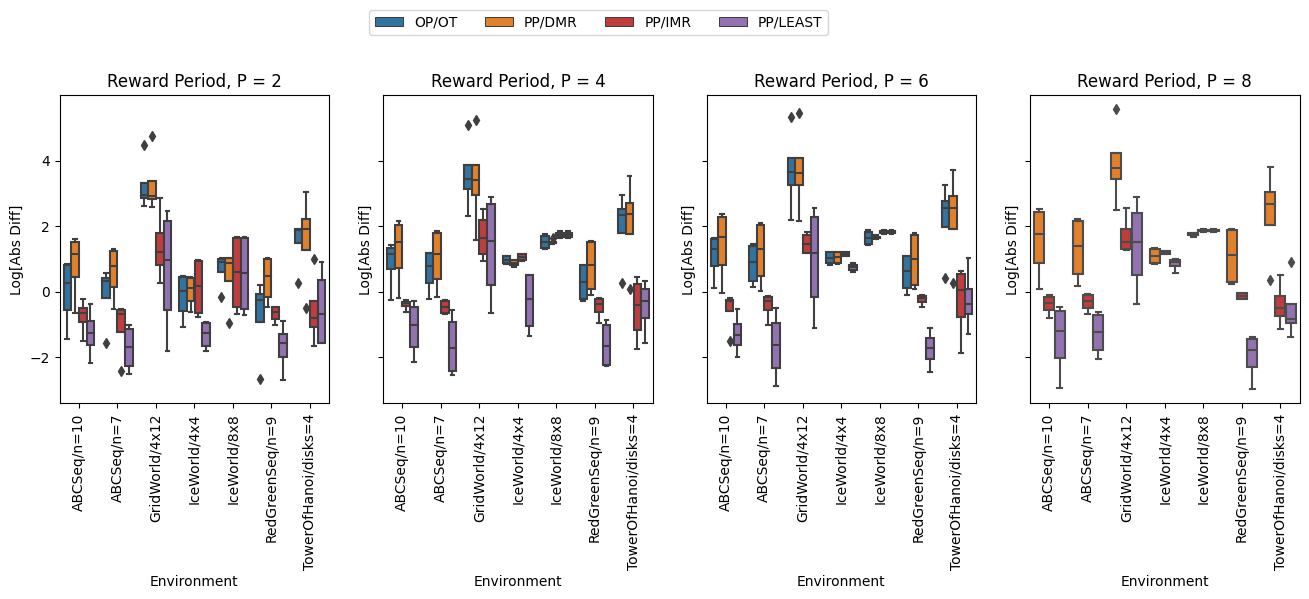

In [19]:
plot_regret(dfs_regret["one-step"][dfs_regret["one-step"]["reward_period"] < 16], suffix="one-step_all")

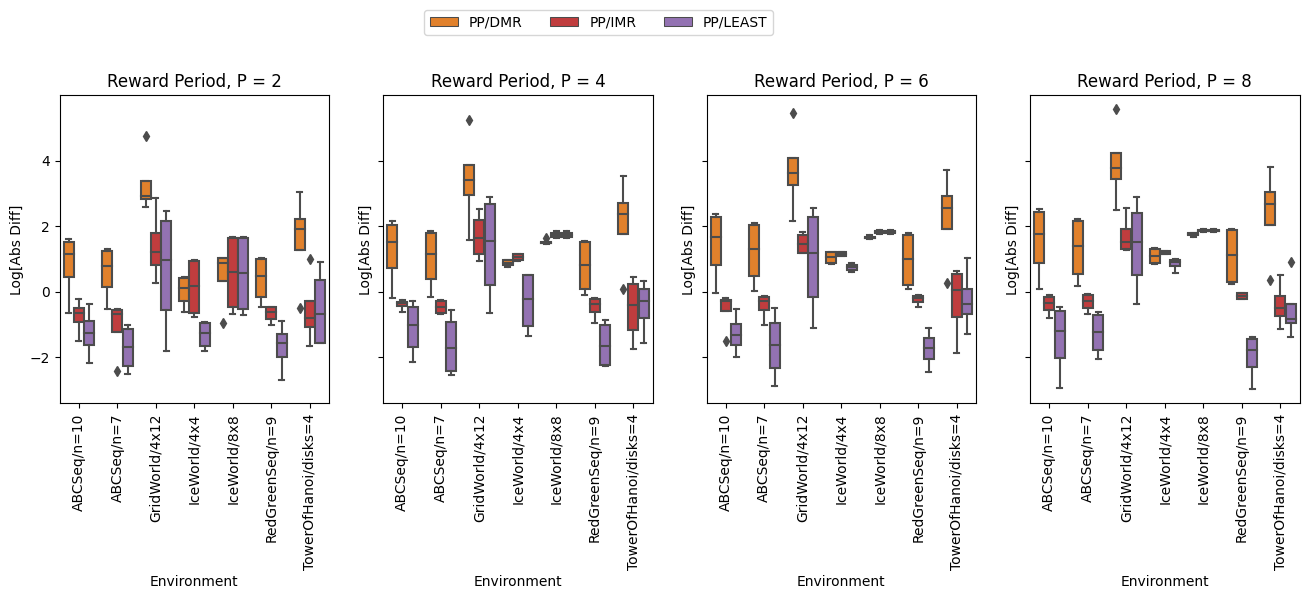

In [20]:

plot_regret(dfs_regret["one-step"], method_filter_fn=lambda x: "OP/OT" not in x, suffix="one-step_nooptions")

### N-step

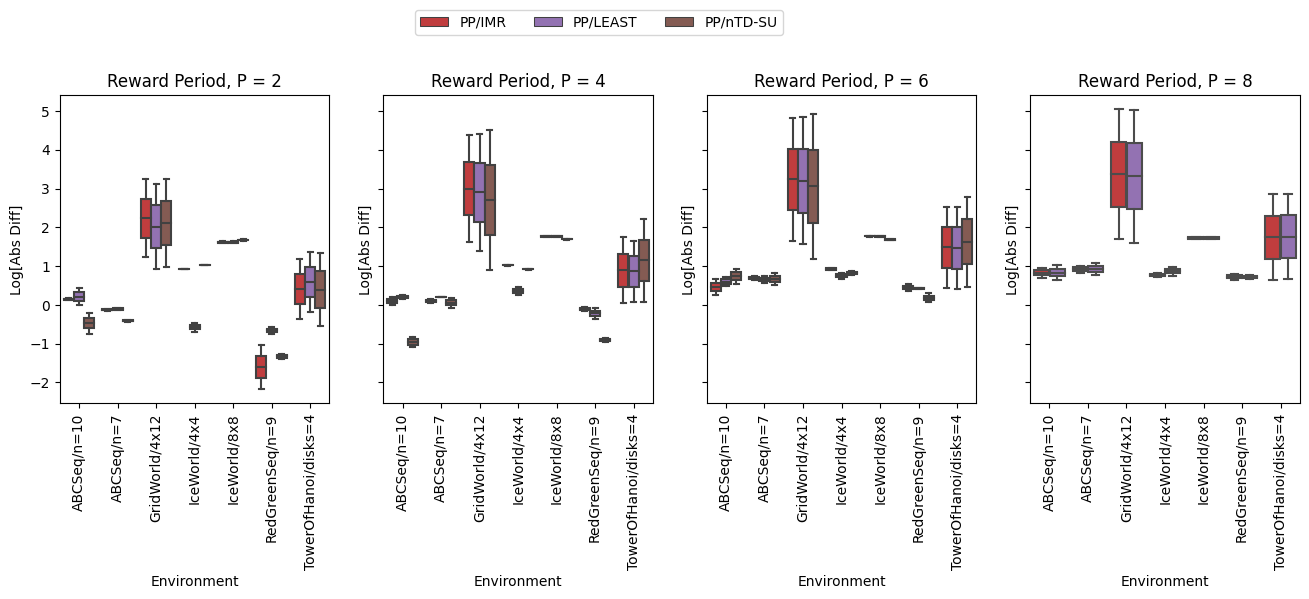

In [21]:
plot_regret(dfs_regret["n-step"], suffix="n-step_all")

## For Print

### Log(relative regret - %)

In [22]:
def print_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/abs_diff"):
    df_raw = df_data[["env", "reward_period", "method", "abs_diff"]]
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]    
    rps = df_raw["reward_period"].unique()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for rp in rps:
        df_plot = df_raw[df_raw["reward_period"] == rp]        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
        sns.boxplot(
            df_plot, 
            x="env", y="abs_diff", 
            hue="method",
            palette=PALETTES,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Log[Abs Diff]")
        ax.set_title(f"Reward Period, P = {rp}")
        name = f"regret_{suffix}_rp{rp}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

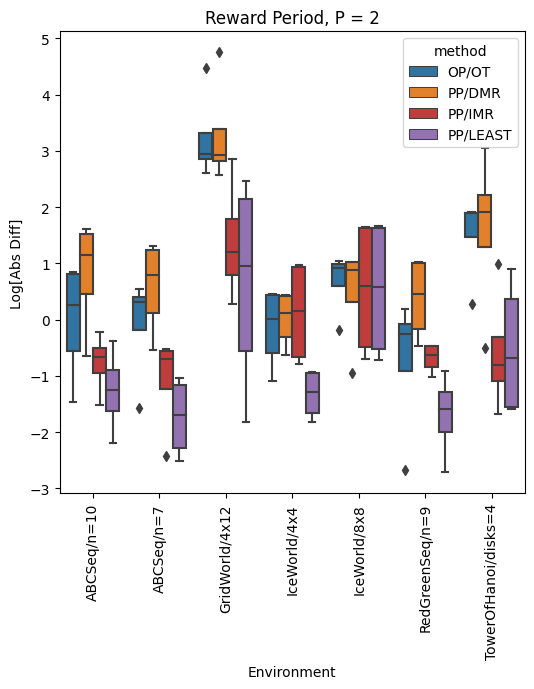

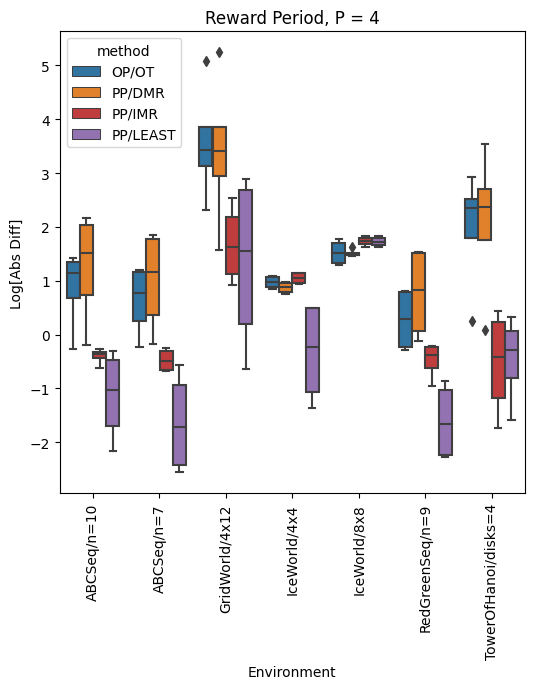

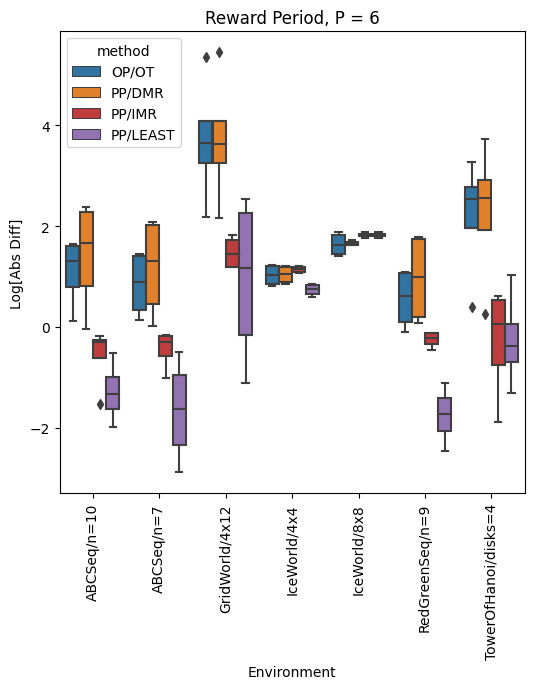

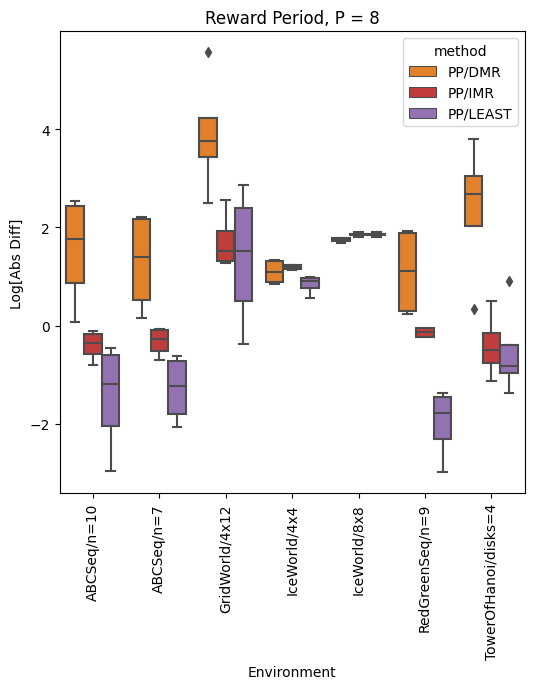

In [23]:
print_regret(dfs_regret["one-step"][dfs_regret["one-step"]["reward_period"] < 16], suffix="one-step_all")

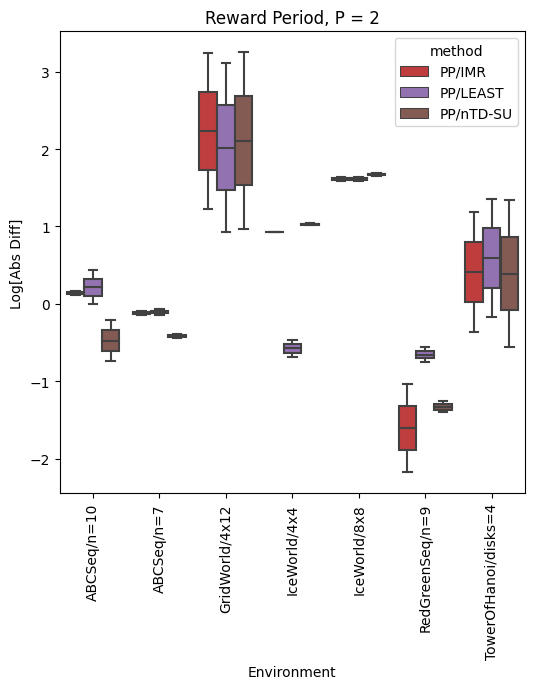

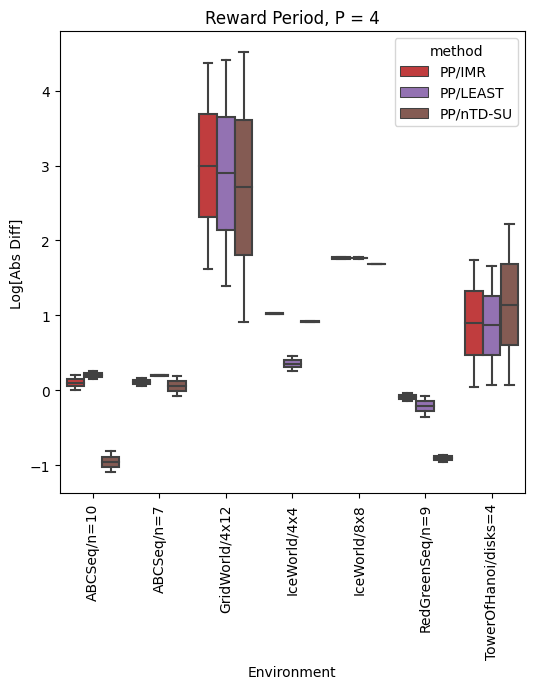

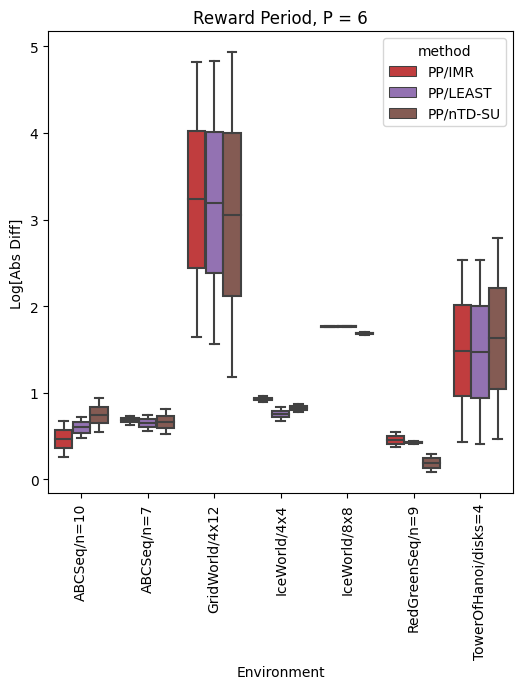

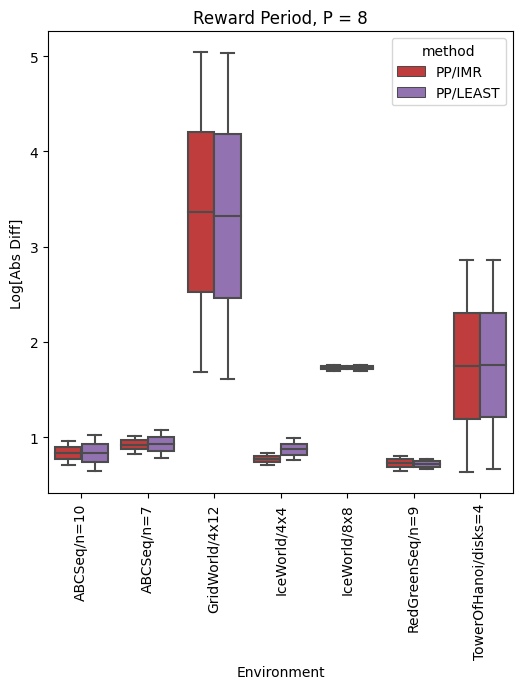

In [24]:
print_regret(dfs_regret["n-step"], suffix="n-step_all")

### Regret per Env

In [25]:
def plot_regret_dist(df_data, suffix, output_dir="figures/abs_diff"):
    names = sorted(df_data["env"].unique())
    for name in names:
        env, args = name.split("/")
        df_slice = df_data[df_data["env"] == name]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.kdeplot(
            data=df_slice, 
            x="abs_diff", 
            hue="method", 
            palette=PALETTES,
            ax=ax
        )
        # ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Log[Abs Diff]")
        # ax.set_ylabel("")
        ax.set_title(f"Environment = {name}")
        name = f"regret_{suffix}_env_{env}_{args}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

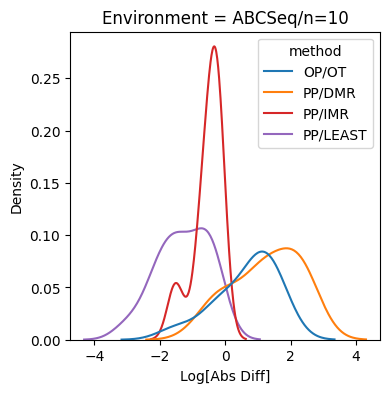

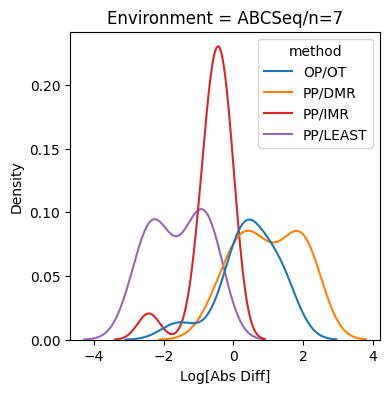

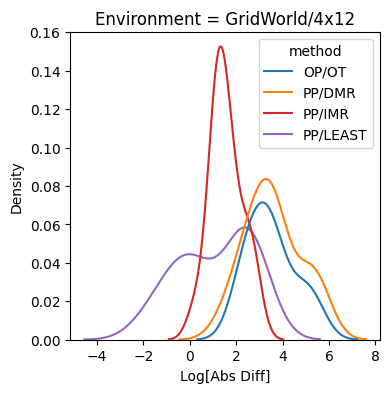

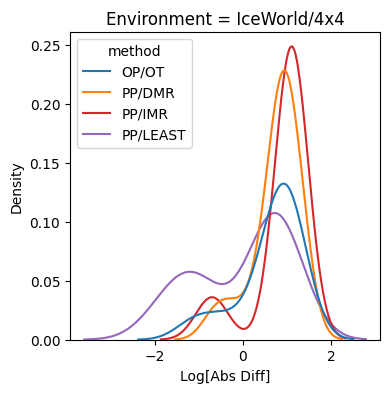

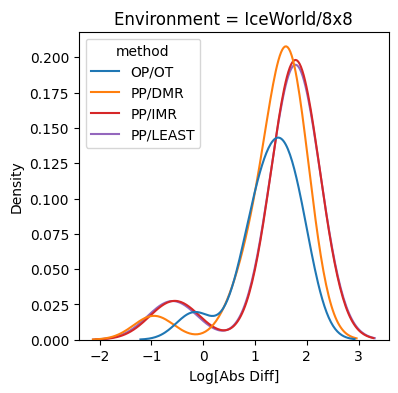

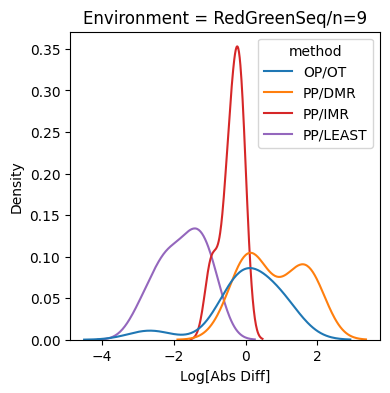

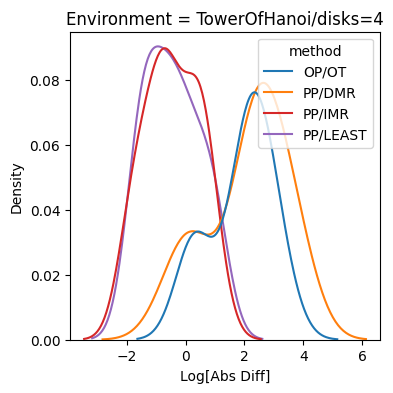

In [26]:
plot_regret_dist(dfs_regret["one-step"][dfs_regret["one-step"]["reward_period"] < 16], "one-step")

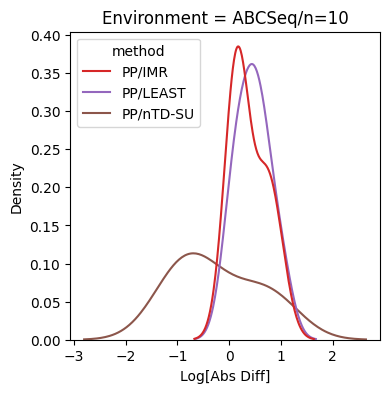

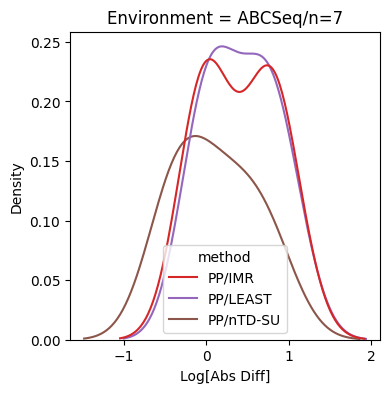

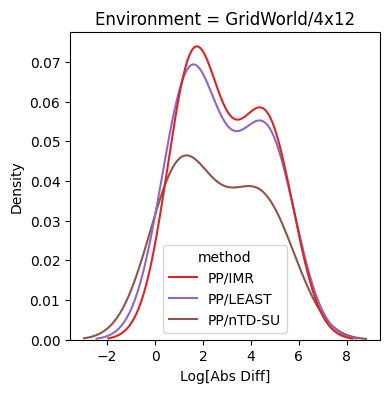

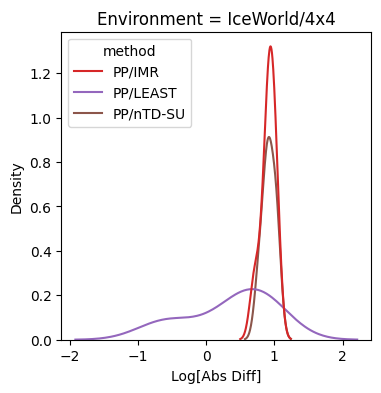

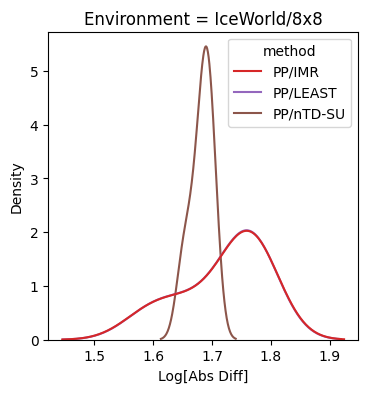

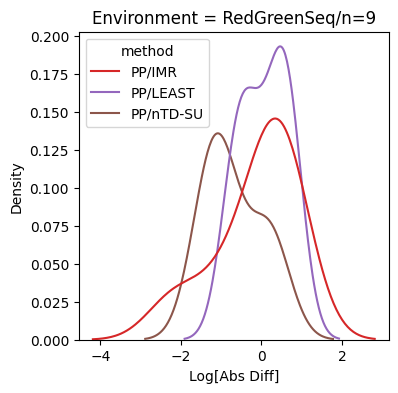

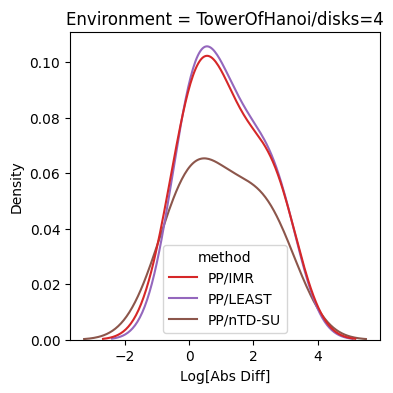

In [27]:
plot_regret_dist(dfs_regret["n-step"], "n-step")